<a href="https://colab.research.google.com/github/selyraa/2141720005-machine-learning-2023/blob/main/JS10-Recurrent%20Neural%20Network%20(RNN)/praktikum_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Praktikum 1
RNN untuk Analisis Sentimen

## Setup
Impor matplotlib dan buat fungsi pembantu untuk memplot grafik:

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline
Dataset ulasan film IMDB adalah kumpulan data klasifikasi biner—semua ulasan memiliki sentimen positif atau negatif.

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Awalnya ini mengembalikan dataset (teks, pasangan label):

In [7]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Berikutnya acak data untuk pelatihan dan membuat kumpulan pasangan (teks, label) ini:

In [8]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b"Hayao Miyazaki name became prominent with Spitied Away, however what is often overlooked are director's first film efforts. Who remembers that Spielberg directed Duel or George Lucas directed THX 1138? I remember seeing fragments of this movie - almost certainly the last 45 minutes in late 80s and what stuck with me was the visual lushness of the design and animation. So when I found a copy in a well known store for \xc2\xa39 I couldn't resist but buy it. The odd thing is that the last 45 minutes of the movie do not tally with my memory of it (memory is funny that way).<br /><br />Viewing this movie now with all the gained knowledge of artists portfolios is how very like Jean 'Moebius' Giraud some of the artwork is. I can only assume some influence here.<br /><br />When Pazu catches a falling girl (Sheeta) his adventure really begins - the quest for Laputa - a reference to Jonathan Swift's overlooked portion of Gulliver's Travels. With healthy references to Jules Verne it's 

## Buat Teks Encoder
Teks mentah yang dimuat oleh tfds perlu diproses sebelum dapat digunakan dalam model. Cara termudah memproses teks untuk pelatihan adalah menggunakan lapisan TextVectorization. Lapisan ini memiliki banyak kemampuan, namun pada tutorial ini menggunakan perilaku default. Buat lapisan tersebut, dan teruskan teks kumpulan data ke metode .adapt lapisan:

In [9]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

Metode .adapt mengatur kosakata lapisan. 20 token pertama dapat dilihat dengan kode berikut. Setelah padding dan token yang tidak diketahui, mereka diurutkan berdasarkan frekuensi:

In [11]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Setelah kosakata diatur, lapisan dapat mengkodekan teks ke dalam indeks. Tensor indeks diberi bantalan 0 ke urutan terpanjang dalam batch (kecuali jika Anda menetapkan output_sequence_length tetap):

In [12]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  1,   1, 398, ...,   0,   0,   0],
       [ 11,  18,  14, ...,   0,   0,   0],
       [  4,  53, 736, ...,   0,   0,   0]])

Dengan pengaturan default, prosesnya tidak dapat dibalik sepenuhnya. Ada dua alasan utama untuk itu:
- Nilai default untuk argumen standarisasi preprocessing.TextVectorization adalah "lower_and_strip_punctuation".
- Ukuran kosa kata yang terbatas dan kurangnya fallback berbasis karakter menghasilkan beberapa token yang tidak diketahui.

In [13]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"Hayao Miyazaki name became prominent with Spitied Away, however what is often overlooked are director's first film efforts. Who remembers that Spielberg directed Duel or George Lucas directed THX 1138? I remember seeing fragments of this movie - almost certainly the last 45 minutes in late 80s and what stuck with me was the visual lushness of the design and animation. So when I found a copy in a well known store for \xc2\xa39 I couldn't resist but buy it. The odd thing is that the last 45 minutes of the movie do not tally with my memory of it (memory is funny that way).<br /><br />Viewing this movie now with all the gained knowledge of artists portfolios is how very like Jean 'Moebius' Giraud some of the artwork is. I can only assume some influence here.<br /><br />When Pazu catches a falling girl (Sheeta) his adventure really begins - the quest for Laputa - a reference to Jonathan Swift's overlooked portion of Gulliver's Travels. With healthy references to Jules Verne it'

## Buat Model

In [14]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [17]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [21]:
for i, layer in enumerate(model.layers):
    print(f"Lapisan {i}: {layer}")


Lapisan 0: <keras.src.layers.preprocessing.text_vectorization.TextVectorization object at 0x7b1b1ff4cd00>
Lapisan 1: <keras.src.layers.core.embedding.Embedding object at 0x7b1b260728f0>
Lapisan 2: <keras.src.layers.rnn.bidirectional.Bidirectional object at 0x7b1b26073820>
Lapisan 3: <keras.src.layers.core.dense.Dense object at 0x7b1b26070dc0>
Lapisan 4: <keras.src.layers.core.dense.Dense object at 0x7b1b26070c10>


Untuk memastikan bahwa ini berfungsi seperti yang diharapkan, evaluasi sebuah kalimat dua kali. Pertama, satu kalimat sehingga tidak ada bantalan (padding) untuk disamarkan:

In [18]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 9s 9s/step
[-0.00950202]


Sekarang, evaluasi lagi dalam batch dengan kalimat yang lebih panjang. Hasilnya harus sama:

In [19]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 63ms/step
[-0.00950202]


compile model Keras untuk mengonfigurasi proses pelatihan:

In [20]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train Model

In [22]:
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset, validation_steps=30)

Epoch 1/10
391/391 [==============================] - 53s 107ms/step - loss: 0.6147 - accuracy: 0.5989 - val_loss: 0.4563 - val_accuracy: 0.8057
Epoch 2/10
391/391 [==============================] - 29s 73ms/step - loss: 0.3850 - accuracy: 0.8260 - val_loss: 0.3609 - val_accuracy: 0.8323
Epoch 3/10
391/391 [==============================] - 28s 71ms/step - loss: 0.3375 - accuracy: 0.8518 - val_loss: 0.3708 - val_accuracy: 0.8516
Epoch 4/10
391/391 [==============================] - 25s 65ms/step - loss: 0.3223 - accuracy: 0.8605 - val_loss: 0.3330 - val_accuracy: 0.8536
Epoch 5/10
391/391 [==============================] - 26s 66ms/step - loss: 0.3140 - accuracy: 0.8633 - val_loss: 0.3301 - val_accuracy: 0.8599
Epoch 6/10
391/391 [==============================] - 26s 67ms/step - loss: 0.3117 - accuracy: 0.8638 - val_loss: 0.3224 - val_accuracy: 0.8568
Epoch 7/10
391/391 [==============================] - 25s 62ms/step - loss: 0.3058 - accuracy: 0.8686 - val_loss: 0.3341 - val_accuracy

In [23]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 12s 30ms/step - loss: 0.3217 - accuracy: 0.8580
Test Loss: 0.3216610252857208
Test Accuracy: 0.8579999804496765


(0.0, 0.6303836017847061)

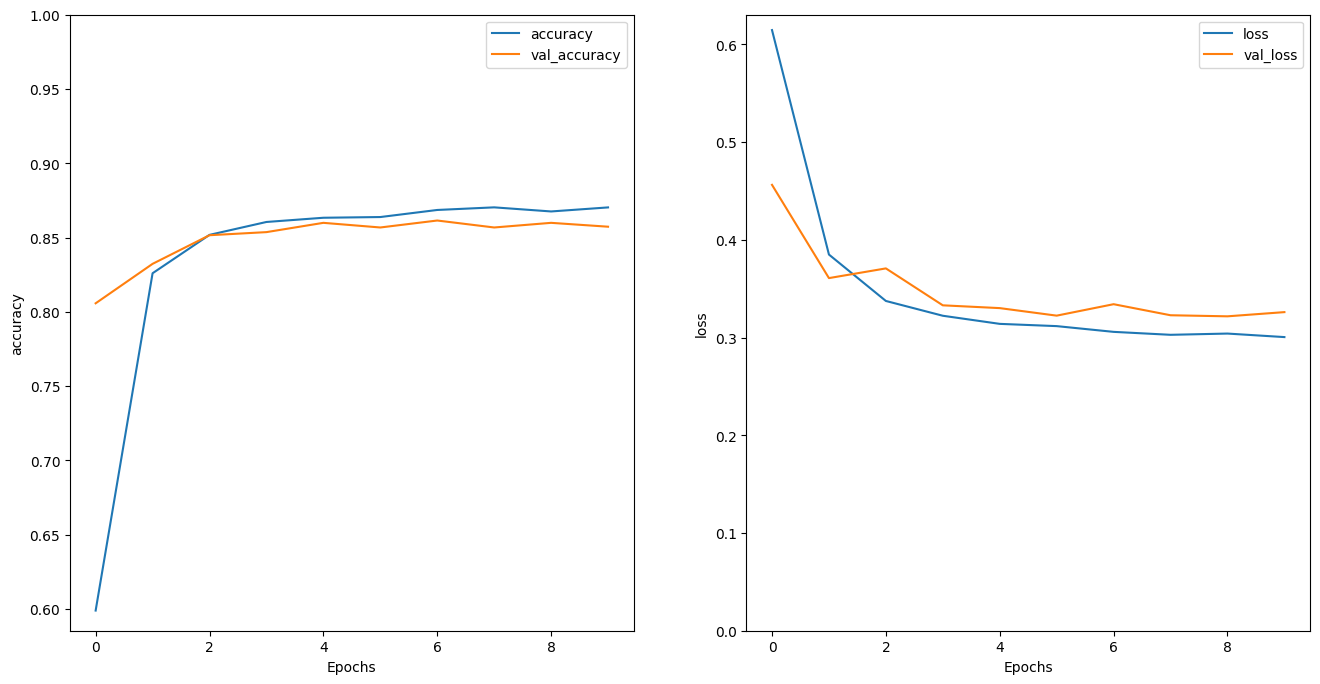

In [24]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Jalankan prediksi pada kalimat baru:

Jika prediksi >= 0,0 berarti positif, jika tidak maka negatif.

In [28]:
sample_text = ('The movie was cool. The animation and the graphics '
                'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 0s 83ms/step
[0.71019655]


## Stack two or more LSTM layers
Hal yang menarik dari penggunaan RNN dengan return_sequences=True adalah outputnya masih memiliki 3 axis, sama seperti inputnya, sehingga bisa diteruskan ke layer RNN lain, seperti ini:

In [30]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [31]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [32]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 80s 158ms/step - loss: 0.6289 - accuracy: 0.5749 - val_loss: 0.4206 - val_accuracy: 0.8182
Epoch 2/10
391/391 [==============================] - 50s 128ms/step - loss: 0.3816 - accuracy: 0.8312 - val_loss: 0.3636 - val_accuracy: 0.8240
Epoch 3/10
391/391 [==============================] - 49s 125ms/step - loss: 0.3341 - accuracy: 0.8563 - val_loss: 0.3457 - val_accuracy: 0.8354
Epoch 4/10
391/391 [==============================] - 52s 132ms/step - loss: 0.3212 - accuracy: 0.8636 - val_loss: 0.3346 - val_accuracy: 0.8516
Epoch 5/10
391/391 [==============================] - 51s 131ms/step - loss: 0.3128 - accuracy: 0.8671 - val_loss: 0.3254 - val_accuracy: 0.8505
Epoch 6/10
391/391 [==============================] - 49s 125ms/step - loss: 0.3071 - accuracy: 0.8674 - val_loss: 0.3238 - val_accuracy: 0.8578
Epoch 7/10
391/391 [==============================] - 50s 128ms/step - loss: 0.3084 - accuracy: 0.8674 - val_loss: 0.3238 - val_ac

In [33]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 21s 53ms/step - loss: 0.3261 - accuracy: 0.8642
Test Loss: 0.3260674476623535
Test Accuracy: 0.8641999959945679


In [34]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
                'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 6s 6s/step
[[-2.0175827]]


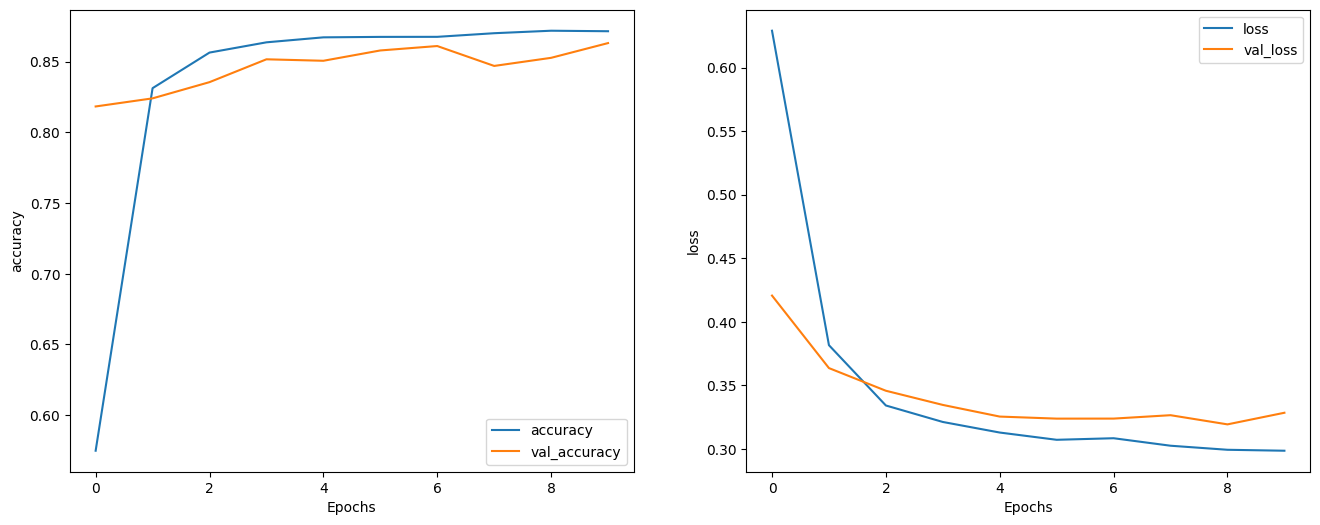

In [35]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')